In [ ]:
!pip install livelossplot
!pip install imageio-ffmpeg

In [ ]:
# Colab uses a Python install that deviates from the system's! Bad collab! We need some workarounds.
!apt purge python3-cairo
!apt install libcairo2-dev pkg-config python3-dev
!pip install --force-reinstall pycairo
!pip install zstandard

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Package 'python3-cairo' is not installed, so not removed
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3-dev is already the newest version (3.10.6-1~22.04.1).
python3-dev set to manually installed.
The following packages were automatically installed and are no longer required:
  libbz2-dev libpkgconf3 libreadline-dev
Use 'apt autoremove' to remove them.
The following additional packages will be installed:
  libblkid-dev libblkid1 libcairo-script-interpreter2 libffi-dev libglib2.0-dev libglib2.0-dev-bin
  libice-dev liblzo2-2 libmount-dev libmount1 libpixman-1-dev libselinux1-dev libsepol-dev
  libsm-dev libxcb-render0-dev libxcb-shm0-dev
Suggested packages:
  libcairo2-doc libgirepository1.0-dev libglib2.0-doc libgdk-pixbuf2.0-bin | libgdk-pixbuf2.0-dev
  libxml2-utils li

In [ ]:
#@title Hepler Functions and Imports
import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch

import time
from livelossplot import PlotLosses
import copy
import tqdm


In [ ]:
import sys

In [ ]:


def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler=None,
                num_epochs=25, save_checkpoints=None, return_best_val=False, checkpoint_path=None):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    since = time.time()
    liveloss = PlotLosses()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 0.0

    for epoch in range(num_epochs):

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                continue
                # model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i,inputs in enumerate(dataloaders):
                inputs = inputs.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs[...,:-1])
                    loss = criterion(outputs, inputs[...,-1:])

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        if scheduler is not None:
                            scheduler.step(loss)

                # statistics
                running_loss += loss.item() * inputs.size(0)
                print("\rIteration: {}/{}, Loss: {}.".format(i+1, len(dataloaders), loss.item() * inputs.size(0)), end="")

                sys.stdout.flush()


            epoch_loss = running_loss / dataset_sizes
            if phase == 'train':
                avg_loss = epoch_loss
                val_loss = epoch_loss


            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

            if save_checkpoints is not None and phase== 'val':
                if epoch in save_checkpoints:
                    save_model = copy.deepcopy(model)
                    torch.save(save_model,f'{checkpoint_path}_{epoch}_{epoch_loss:.3f}_{val_loss:.3f}.pt')


        liveloss.update({
            'log loss': avg_loss,
        })

        liveloss.draw()
        print('Train Loss: {:.4f} Acc: {:.4f}'.format(avg_loss, 0))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    # load best model weights
    if return_best_val:
        model.load_state_dict(best_model_wts)

    return model

def get_mgrid(sidelen):

    # Generate 2D pixel coordinates from an image of sidelen x sidelen
    pixel_coords = np.stack(np.mgrid[:sidelen,:sidelen], axis=-1)[None,...].astype(np.float32)
    pixel_coords /= sidelen
    pixel_coords -= 0.5
    pixel_coords = torch.Tensor(pixel_coords).view(-1, 2)
    return pixel_coords

In [ ]:
img = plt.imread('/content/metfaces_3-removebg-preview.jpg').mean(-1)

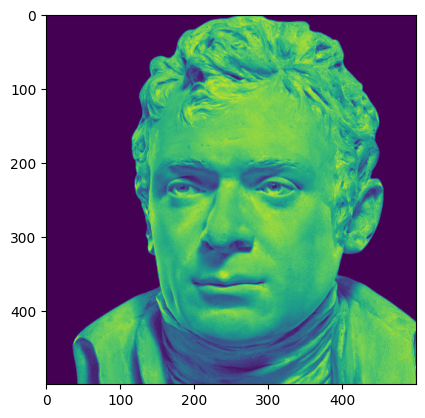

In [ ]:
#plt.figure(figsize=(1,1))
plt.imshow(img)

In [ ]:
sidelen = img.shape[0]
x = get_mgrid(sidelen)
y = torch.tensor(img.reshape(-1,1))
inputs = torch.hstack([x,y])
inputs = inputs.type(torch.float32)
dataloader = torch.utils.data.DataLoader(inputs,
                                         batch_size=128,
                                         pin_memory=True,
                                         shuffle=True)

In [ ]:
##model def

width = 256
depth = 6


layers = []

act = torch.nn.SiLU()

layers.append(torch.nn.Linear(2,width))
layers.append(act)


for i in range(depth-1):
    layers.append(torch.nn.Linear(width,width))
    layers.append(act)

layers.append(torch.nn.Linear(width,1))

model = torch.nn.Sequential(*layers)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

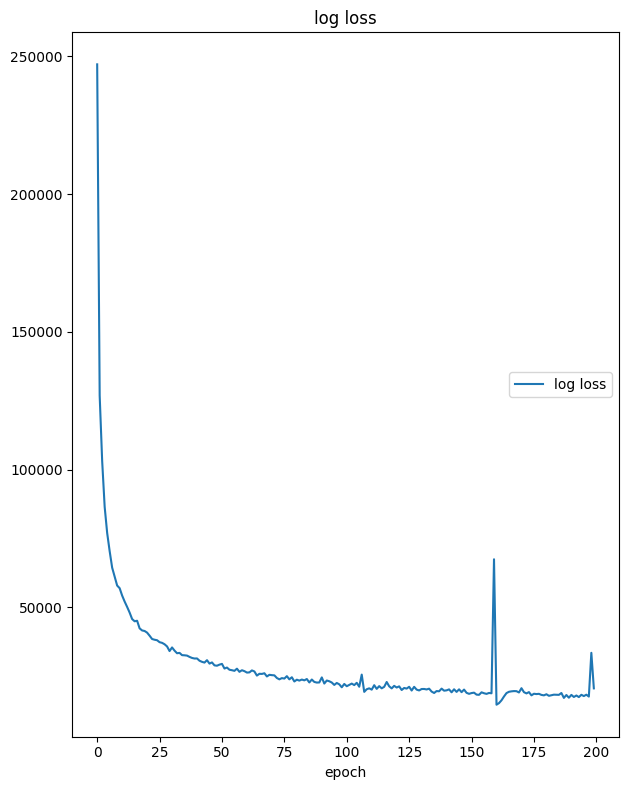

log loss
	log loss         	 (min: 14708.861, max: 247045.381, cur: 20631.172)
Train Loss: 20631.1718 Acc: 0.0000

Training complete in 29m 4s


In [ ]:
criterion = torch.nn.MSELoss()

model = train_model(model.cuda(),optimizer=optimizer,
            dataloaders=dataloader,
            criterion=criterion,
            dataset_sizes=len(dataloader),
            num_epochs=200,
           )

In [ ]:


torch.save(model.state_dict(), 'inr_silu_weights_james_bond.pth')

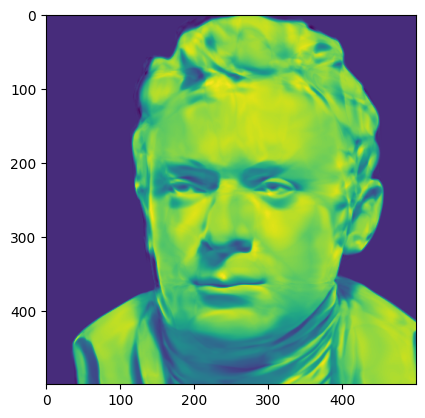

In [ ]:
with torch.no_grad():
    plt.imshow(model.float().forward(x.cuda()).reshape(sidelen,sidelen).cpu().numpy())

In [ ]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def fn(out_pre,model_dict_ls,li):
    if li == len(model_dict_ls)/2:
        return out_pre
    out_cur = []
    for i in range(len(model_dict_ls[2*li])):
        x = 0
        for j in range(len(out_pre)):
            x = x + out_pre[j]*model_dict_ls[2*li][i][j]
        if li == (len(model_dict_ls)/2)-1:
            out_cur.append(((x+model_dict_ls[2*li+1][i])*sigmoid(x+model_dict_ls[2*li+1][i])))
        else:
            out_cur.append((x+model_dict_ls[2*li+1][i])*sigmoid(x+model_dict_ls[2*li+1][i]))
    li+=1
    return fn(np.array(out_cur),model_dict_ls,li)

#0.5

Accuracy: 0.0


<ipython-input-18-9c9a21c92f84>:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


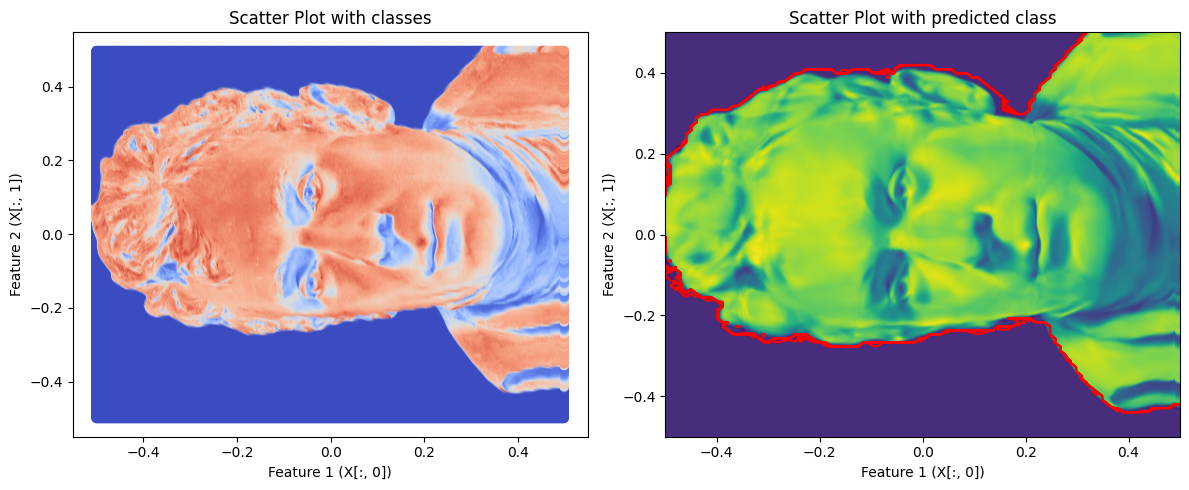

In [ ]:
X3 = dataloader.__dict__['dataset'][:,:-1]
c = dataloader.__dict__['dataset'][:,-1].numpy()
y3 = dataloader.__dict__['dataset'][:,-1].numpy()

X3_tensor = X3#torch.from_numpy(X3).float()

# Make predictions
with torch.no_grad():
    predicted = model(X3_tensor.cuda().float()).type(model.parameters().__next__().dtype).cpu().numpy()
    #predictions = (predicted > 0.5).astype(int)
    predictions = predicted.flatten()

# Calculate the accuracy
accuracy = np.mean(predictions == y3)
print("Accuracy:", accuracy)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))



#plt.xlim([domain[0][0],domain[2][0]])
#plt.ylim([domain[0][1],domain[2][1]])

# Plot the color-coded classification
ax1.scatter(X3[:, 0], X3[:, 1], c=y3, cmap='coolwarm')
ax1.set_xlabel('Feature 1 (X[:, 0])')
ax1.set_ylabel('Feature 2 (X[:, 1])')
ax1.set_title('Scatter Plot with classes')

domain = torch.tensor([
    [-.5,-.5],
    [-.5,.5],
    [.5,.5],
    [.5,-.5],
    [-.5,-.5]
])

# Plot the second graph (Scatter Plot with predicted class)
ax2.scatter(X3[:, 0], X3[:, 1], c=predictions, cmap='viridis')
x2 = np.linspace(domain[0][0],domain[2][0], 100)
y2 = np.linspace(domain[0][1],domain[2][1], 100)
X2, Y2 = np.meshgrid(x2, y2)
#Z2 = (model2.fc2.weight.data[0][0]*(1/(1+np.exp((-model2.fc1.weight.data[0][0])* X2 - model2.fc1.weight.data[0][1]* Y2 - model2.fc1.bias.data[0])))) +(model2.fc2.weight.data[0][1]*(1/(1+ np.exp(-model2.fc1.weight.data[1][0] * X2 - model2.fc1.weight.data[1][1]*Y2 - model2.fc1.bias.data[1])))) +model2.fc2.bias.data[0]
model_dict_ls = [np.array(ls.cpu()) for ls in list(model.state_dict().values())]
Z = fn(np.array([X2,Y2]),model_dict_ls,0)[0]
# Plot the equation as a contour line
plt.contour(X2, Y2, Z, levels=[0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9], colors='red')
ax2.set_xlabel('Feature 1 (X[:, 0])')
ax2.set_ylabel('Feature 2 (X[:, 1])')
ax2.set_title('Scatter Plot with predicted class')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

Accuracy: 0.0


<ipython-input-18-9c9a21c92f84>:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


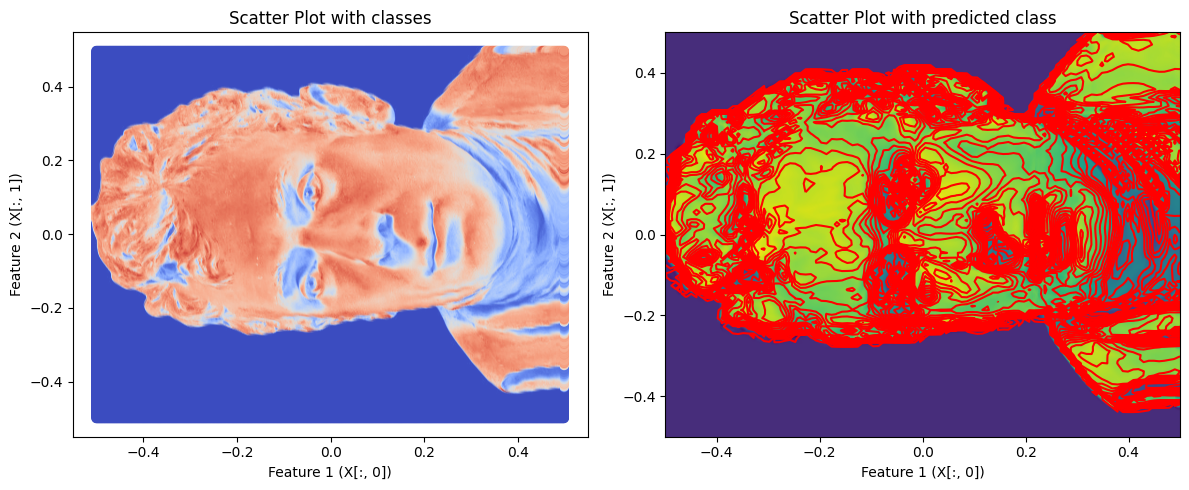

In [ ]:
X3 = dataloader.__dict__['dataset'][:,:-1]
c = dataloader.__dict__['dataset'][:,-1].numpy()
y3 = dataloader.__dict__['dataset'][:,-1].numpy()

X3_tensor = X3#torch.from_numpy(X3).float()

# Make predictions
with torch.no_grad():
    predicted = model(X3_tensor.cuda().float()).type(model.parameters().__next__().dtype).cpu().numpy()
    #predictions = (predicted > 0.5).astype(int)
    predictions = predicted.flatten()

# Calculate the accuracy
accuracy = np.mean(predictions == y3)
print("Accuracy:", accuracy)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))



#plt.xlim([domain[0][0],domain[2][0]])
#plt.ylim([domain[0][1],domain[2][1]])

# Plot the color-coded classification
ax1.scatter(X3[:, 0], X3[:, 1], c=y3, cmap='coolwarm')
ax1.set_xlabel('Feature 1 (X[:, 0])')
ax1.set_ylabel('Feature 2 (X[:, 1])')
ax1.set_title('Scatter Plot with classes')

domain = torch.tensor([
    [-.5,-.5],
    [-.5,.5],
    [.5,.5],
    [.5,-.5],
    [-.5,-.5]
])

# Plot the second graph (Scatter Plot with predicted class)
ax2.scatter(X3[:, 0], X3[:, 1], c=predictions, cmap='viridis')
x2 = np.linspace(domain[0][0],domain[2][0], 100)
y2 = np.linspace(domain[0][1],domain[2][1], 100)
X2, Y2 = np.meshgrid(x2, y2)
#Z2 = (model2.fc2.weight.data[0][0]*(1/(1+np.exp((-model2.fc1.weight.data[0][0])* X2 - model2.fc1.weight.data[0][1]* Y2 - model2.fc1.bias.data[0])))) +(model2.fc2.weight.data[0][1]*(1/(1+ np.exp(-model2.fc1.weight.data[1][0] * X2 - model2.fc1.weight.data[1][1]*Y2 - model2.fc1.bias.data[1])))) +model2.fc2.bias.data[0]
model_dict_ls = [np.array(ls.cpu()) for ls in list(model.state_dict().values())]
Z = fn(np.array([X2,Y2]),model_dict_ls,0)[0]
# Plot the equation as a contour line
plt.contour(X2, Y2, Z, levels=[0,1,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230], colors='red')
ax2.set_xlabel('Feature 1 (X[:, 0])')
ax2.set_ylabel('Feature 2 (X[:, 1])')
ax2.set_title('Scatter Plot with predicted class')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

In [ ]:
max(y3)

239.66667